# Gateway Lesson


This is a PGC Data Workshop Gateway Lesson, which is your introduction to a foundational concept **_coregistration_** and key skills to model a glacier elevation change. This lesson prepares you for topics such as analysis of DEM accuracy, differnecing, and DEM coregistration. So with that said:

## Welcome to the Coregistration Exercise!

<br>

Lesson Developer: 
  * Ali Hossaini (hossa084@umn.edu)


# DEM: Gridded Representations of Elevation

Digital Elevation Models (DEMs) serve as numerical, gridded representations of elevation, deriving from diverse instruments (e.g., optical sensors, radar, lidar). They are acquired under varying conditions, including ground, airborne, and satellite platforms, and are processed using different techniques like photogrammetry and remote sensing.

<div> <center>
<td><img src="img/An-example-of-a-Digital-Elevation-Model.png" width="800"/></td> </center>
</div>

> <span style="color:gray">
image source: Barcellos et al., 2007. Surface Flow Animation in Digital Terrain Models. </span>


## DEMs Have Complex Characteristics:

- **Ground Sampling Distance (GSD):** The pixel size, or GSD, doesn't always reflect the actual spatial resolution of the observations.

- **Georeferencing Challenges:** Georeferencing is prone to shifts, tilts, or deformations due to inherent instrument errors, noise, or associated processing schemes.

- **Outlier Abundance:** DEMs often contain numerous outliers that are challenging to filter, stemming from diverse sources like photogrammetric errors and cloud interference.

These factors contribute to the complexity of assessing the <b>accuracy</b> and <b>precision</b> of DEMs, a crucial step for any subsequent analysis.

<div> <center>
<td><img src="img/800px-Grancanaria-meshlab-vs-meshmixer.png" width="800"/></td> </center>
</div>

> <span style="color:gray">
    image source: edutechwiki.unige.ch </span>



## All DEMs Have Some Horizontal and Vertical Geolocation Error. 

The **spatial structure of DEMs** introduces complexity to the concepts of <b>accuracy</b> and <b>precision</b>. For example:

Spatially structured systematic errors are often associated with the gridded nature of DEMs, leading to affine biases. Additionally, specific biases can exist at the pixel scale. Concerning random errors, there is a variability in error magnitude or heteroscedasticity across the DEM, and spatially structured error patterns are connected to spatial correlations.


!["DEM"](img/Pattern_of_Errors.png)
>[ <span style="color:gray">
    image source: Hugonnet et al. (2022) </span>](https://ieeexplore.ieee.org/document/9815885) Source of errors in DEMs

## Optimizing DEM Accuracy in Relation to Other Georeferenced Data:

Shifts to the true positioning resulting from poor accuracy are common in elevation datasets and can be corrected effectively by performign a **DEM co-registration** with precise and accurate refrence elevation data that undergoes quality control. Quality-controlled DEMs, aligned to high-accuracy data, are also available, such as TanDEM-X global DEM (refer to [Rizzoli et al. (2017)](https://www.sciencedirect.com/science/article/pii/S092427161730093X?via%3Dihub)).

These biases can be addressed using the techniques outlined in **Coregistration**.
<br>
<br>
<center><table><tr>
<div>
<td><img src="img/Co1.png" width="400"/></td>
<td><img src="img/Co2.jpg" width="400"/></td>
</div>
</tr></table></center>

> <span style="color:gray">
    image source: Nuth and Kääb (2011) </span> 

## Coregistration

Coregistration aligns multiple datasets to a common reference, minimizing geometric differences. This involves adjusting the spatial parameters of one dataset to match those of another which: 

- may include transformations such as translation, rotation, scaling, and possibly more complex adjustments to account for distortions in the data.

- is often necessary when merging elevation data from various sources, such as satellite imagery, aerial photographs, LiDAR, or other remote sensing technologies. 

- each dataset may have been acquired at different times, from different platforms, or using different sensors, resulting in variations in spatial orientation, scale, and geometry.


## DEM Coregistration
Coregistration between DEMs correspond to aligning the digital elevation models in three dimensions.

Transformations that can be described by a 3-dimensional affine function are included in coregistration methods which include:

- vertical and horizontal translations

- rotations

- scalings


## Today's Workshop Focus: Greenland's Glacial DEMs

Materials Required:

Two Digital Elevation Models (DEMs) of Greenland (can be obtained from different sources, e.g., NASA DEMs, ArcticDEM, etc.)

Jupyter Notebook with Python and relevant libraries (e.g., rasterio, geopandas, matplotlib)
<br>
<br>
<div><center>
<img src="img/elevChgLatLon_20_rainbowPurpleOrangeBright-3to3_large.png" width="800"/></center>
    
<center><img src="img/greenlandElevCbar.png" width="400" height="20" /></center>
</div>

> [<span style="color:gray">
    image source: NASA </span> ](https://svs.gsfc.nasa.gov/cgi-bin/details.cgi?aid=3410)


## Install/Import Libraries:

Import necessary Python libraries for geospatial analysis by running the following cells (Shift+Enter).



In [55]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import folium
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import Affine
from rasterio.enums import Resampling
from rasterio.crs import CRS
from rasterio.plot import show


# Load DEMs:

Load the two DEMs of Greenland using rasterio.


In [56]:
# Define DEM files
reference_dem_path  = 'DEM/SETSM_s2s041_WV02_20150402_103001003E9F4300_103001004013BE00_2m_seg1_dem_10m.tif'
target_dem_path  = 'DEM/TDX_Greenland_Iceland_Mosaic_90m_Sample.tif'


DEMs do not align with each other:
<div><center>
<img src="img/slide_21.jpg" width="600"/>
</div>

> <span style="color:gray">
    image source: Slide.org </span> 


# Explore Initial Alignment:

Display the two DEMs to observe the misalignment.



In [57]:
# Function to read and display a raster file
def read_and_display_raster(file_path, title, ax=None):
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
        if ax is None:
            fig, ax = plt.subplots()
        show(data, title=title, cmap='terrain', ax=ax)

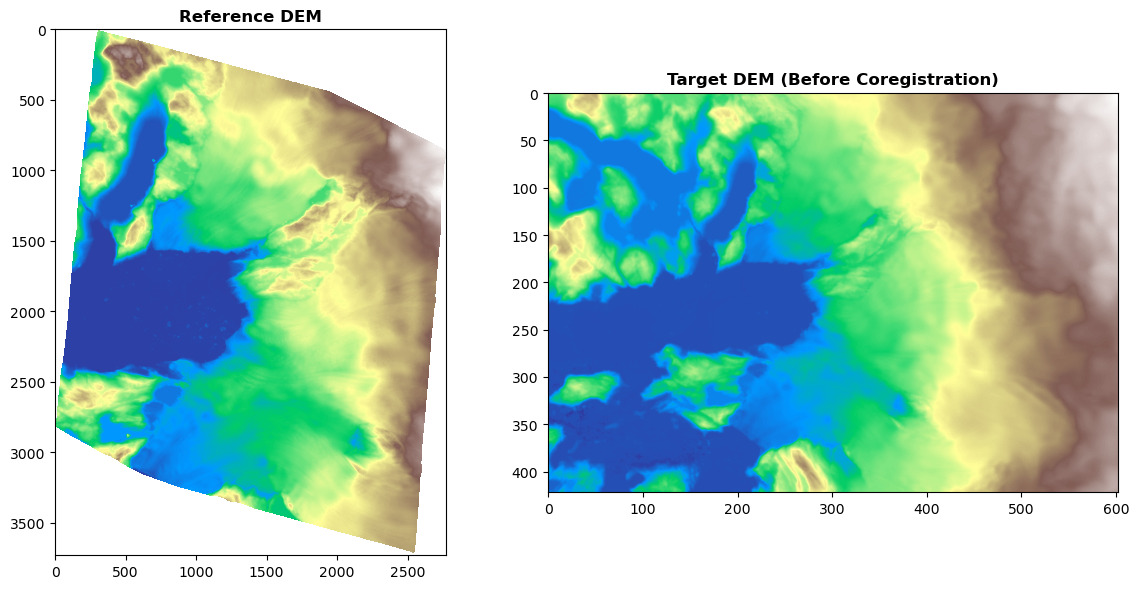

In [58]:
# Read and display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Read and display the reference DEM and the target DEM before coregistration
read_and_display_raster(reference_dem_path, title='Reference DEM', ax=axes[0])
read_and_display_raster(target_dem_path, title='Target DEM (Before Coregistration)', ax=axes[1])

# Show the plot
plt.tight_layout()
plt.show()


# Perform Coregistration:

Coregister one DEM to the other using resampling approach. Coregistration requires that cell centroids align perfectly for all intersecting areas. Resampling is also extremely common during reprojection operations as it often requires changing the orientation, scale or resolution of an image.
<div><center>
<img src="img/slide_22.jpg" width="600"/>
</div>

> <span style="color:gray">
    image source: Slide.org </span> 



## Nearest Neighbour Method:
Nearest Neighbour is a techniquefor resampling raster data in which the value of each cell in an output raster is calculated using the value of the nearest cell in an input raster.
<br>
<br>
<div><center>
<img src="img/nearest-neighbor-300x104.png" width="600"/>
</div>

> <span style="color:gray">
    image source: GISGeography </span> 

## Bilinear Interpolation Method:
Bilinear interpolation is a technique for calculating values of a grid location based on nearby grid cells. The key difference is that it uses the FOUR closest cell centers.

Using the four nearest neighboring cells, bilinear interpolation assigns the output cell value by taking the weighted average. It applies weights based on the distance of the four nearest cell centers smoothing the output raster grid.
<br>
<br>
<div><center>
<img src="img/bilinear-interpolation-425x143.png" width="600"/>
</div>

> <span style="color:gray">
    image source: GISGeography </span> 

In [73]:
#Reproject a file to match the shape and projection of existing raster. 
def coregister_rasters(infile, match, outfile, method):
        # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine:\n',dst_transform)
        # open output
        if method == 'nearest':
            with rasterio.open(outfile, "w", **dst_kwargs) as dst:
                # iterate through bands and write using reproject function
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=dst_transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
        if method == 'bilnear':
            with rasterio.open(outfile, "w", **dst_kwargs) as dst:
                # iterate through bands and write using reproject function
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=dst_transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.bilnear)
                

Coregistered to shape: 422 603 
 Affine:
 | 89.88, 0.00,-223728.98|
| 0.00,-89.88,-2156638.42|
| 0.00, 0.00, 1.00|


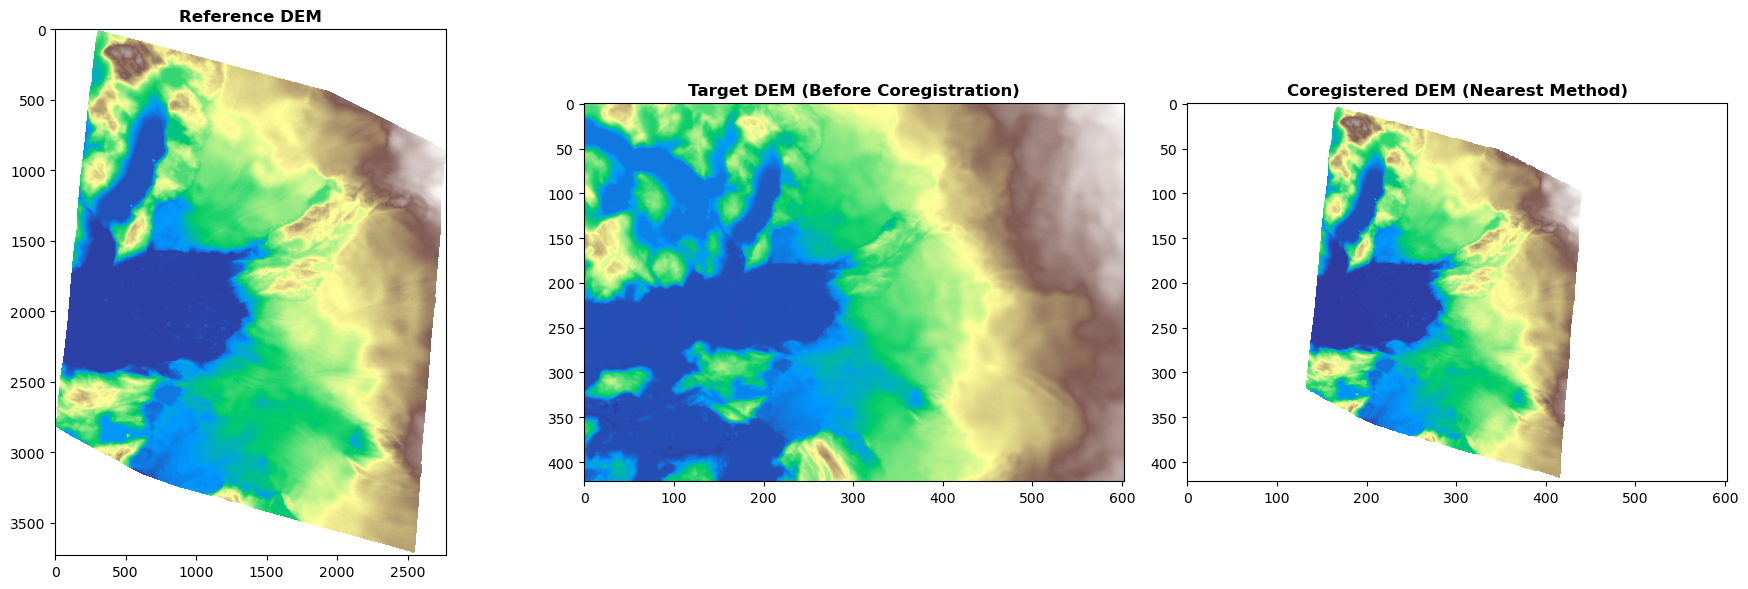

In [74]:
# Coregistered Output file
coregistered_dem = 'DEM/coregistered_nearest.tif'

# Co-register DEMs
coregister_rasters(reference_dem_path, target_dem_path, coregistered_dem, 'nearest')

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Read and display reference DEM and target DEM before and coregistration DEM
read_and_display_raster(reference_dem_path, title='Reference DEM', ax=axes[0])
read_and_display_raster(target_dem_path, title='Target DEM (Before Coregistration)', ax=axes[1])
read_and_display_raster(coregistered_dem, title='Coregistered DEM (Nearest Method)', ax=axes[2])

# Show the plot
plt.tight_layout()
plt.show()

## Bilinear Interpolation Method:
Bilinear interpolation is a technique for calculating values of a grid location based on nearby grid cells. The key difference is that it uses the FOUR closest cell centers.

Using the four nearest neighboring cells, bilinear interpolation assigns the output cell value by taking the weighted average. It applies weights based on the distance of the four nearest cell centers smoothing the output raster grid.
<br>
<br>
<div><center>
<img src="img/bilinear-interpolation-425x143.png" width="600"/>
</div>

> <span style="color:gray">
    image source: GISGeography </span> 

# Interactive  Coregistered DEM:

Display the coregistered DEM.




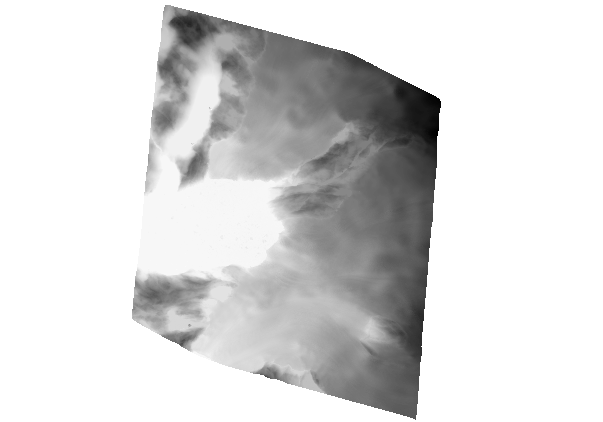

In [61]:
import folium
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Function to read raster file
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1, masked=True), src.meta

# Read the coregistered DEM
coregistered_dem_data, coregistered_dem_metadata = read_raster(coregistered_dem)

# Convert masked array to regular array
coregistered_dem_data = coregistered_dem_data.filled(fill_value=0)  # Replace masked values with 0

# Create a Folium map centered at the coordinates extracted from the metadata
m = folium.Map(location=[coregistered_dem_metadata['transform'][5], coregistered_dem_metadata['transform'][2]])

# Add the coregistered DEM as an overlay
folium.raster_layers.ImageOverlay(
    image=coregistered_dem_data,
    bounds=[[coregistered_dem_metadata['transform'][2], coregistered_dem_metadata['transform'][5]], 
            [coregistered_dem_metadata['transform'][2] + coregistered_dem_metadata['width'] * coregistered_dem_metadata['transform'][0],
             coregistered_dem_metadata['transform'][5] + coregistered_dem_metadata['height'] * coregistered_dem_metadata['transform'][4]]],
    opacity=0.7,
    colormap=lambda x: (0, 0, 0, x),  # Add a colormap
).add_to(m)

# Display the map
m


# 3D Visualization? 

Display the coregistered DEM.

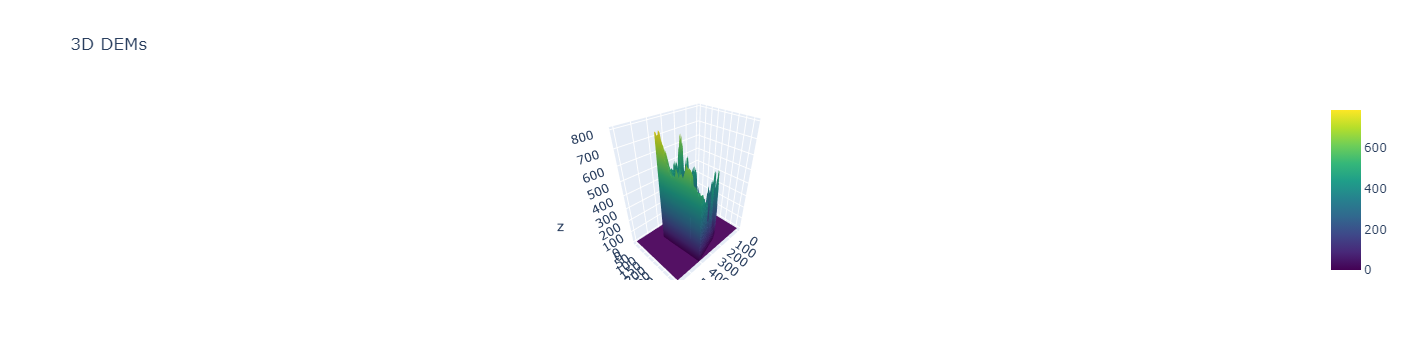

In [62]:
import rasterio
import plotly.graph_objs as go

# Read the DEMs
def read_dem(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1, masked=True), src.meta

coregistered_dem_data, coregistered_dem_metadata = read_dem(coregistered_dem)

# Create surface plots for each DEM
coregistered_surface = go.Surface(z=coregistered_dem_data, colorscale='Viridis', name='Coregistered DEM')

# Create figure
fig = go.Figure(data=[coregistered_surface])

# Update layout
fig.update_layout(title='3D DEMs', scene=dict(aspectmode='data'))

# Show plot
fig.show()


# Save Coregistered DEM:

Save the coregistered DEM for future use.

In [70]:
#Define saving parameters such as folder path, format, coordinate system, etc.
output_path = 'DEM/coregistered_dem_final.tif'
with rasterio.open(output_path, 'w', driver='GTiff', height=reference_dem_path.shape[0], width=reference_dem_path.shape[1],
                   count=1, dtype='float32', crs=reference_dem_path.crs, transform=transform) as dst:
    dst.write(coregistered_dem, 1)


InvalidArrayError: Positional argument arr must be an array-like object

# Advanced Method:

Using **xDEM** package to coregister DEMs:

In [49]:
import xdem

reference_dem = xdem.DEM(reference_dem_path)
dem_to_be_aligned = xdem.DEM(target_dem_path).reproject(reference_dem, silent=True)

nuth_kaab = xdem.coreg.NuthKaab()

# Fit the data to a suitable x/y/z offset.
nuth_kaab.fit(reference_dem.data, dem_to_be_aligned.data, transform=reference_dem.transform, crs=reference_dem.crs)

aligned_dem = nuth_kaab.apply(dem_to_be_aligned)

aligned_dem.save("DEM/coregistered_NuthKaab.tif")

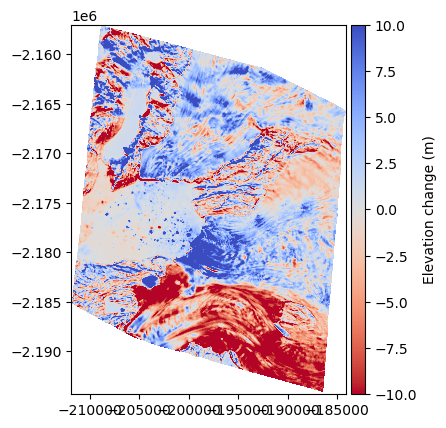

In [54]:
diff_after = reference_dem - aligned_dem
diff_after.show(cmap="coolwarm_r", vmin=-10, vmax=10, cbar_title="Elevation change (m)")

# Next Lesson: Differening for Change Detection Exercise

Thank you!